In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("spark://localhost:7077")\
    .appName("k-meaner")\
    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-common:3.3.6') \
    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.3.6') \
    .config('spark.jars.packages', 'com.amazonaws:aws-java-sdk:1.12.99') \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
    .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')\
    .config('spark.hadoop.fs.s3a.access.key', '9818c1106da845c2a4fcfcab05674abd') \
    .config('spark.hadoop.fs.s3a.secret.key', '7918b4d8db2a45cc8d628c46315b62e6') \
    .config('spark.hadoop.fs.s3a.endpoint', 'https://cloud-areapd.pd.infn.it:5210') \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.metadatastore.impl", "org.apache.hadoop.fs.s3a.s3guard.NullMetadataStore") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled","false") \
    .config("com.amazonaws.sdk.disableCertChecking","true") \
    .getOrCreate()

sc = spark.sparkContext

23/07/10 09:01:24 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
from sklearn.datasets import fetch_kddcup99
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt

# Loading the `kddcup99` dataset

In [3]:
kdd = fetch_kddcup99(return_X_y=True)
n_samples = kdd[0].shape[0]

`kdd` is a tuple where the first element is an array of data points, while the second element is filled with the corresponding labels – i.e., the attack types.

In [4]:
kdd

(array([[0, b'tcp', b'http', ..., 0.0, 0.0, 0.0],
        [0, b'tcp', b'http', ..., 0.0, 0.0, 0.0],
        [0, b'tcp', b'http', ..., 0.0, 0.0, 0.0],
        ...,
        [0, b'tcp', b'http', ..., 0.01, 0.0, 0.0],
        [0, b'tcp', b'http', ..., 0.01, 0.0, 0.0],
        [0, b'tcp', b'http', ..., 0.01, 0.0, 0.0]], dtype=object),
 array([b'normal.', b'normal.', b'normal.', ..., b'normal.', b'normal.',
        b'normal.'], dtype=object))

In [5]:
labels = kdd[1]

Also, we save the number of unique labels; we will need this later when we choose the number of clusters for the `k-means`.

In [6]:
k = len(set(labels))

Let’s examine the distribution of attack types.

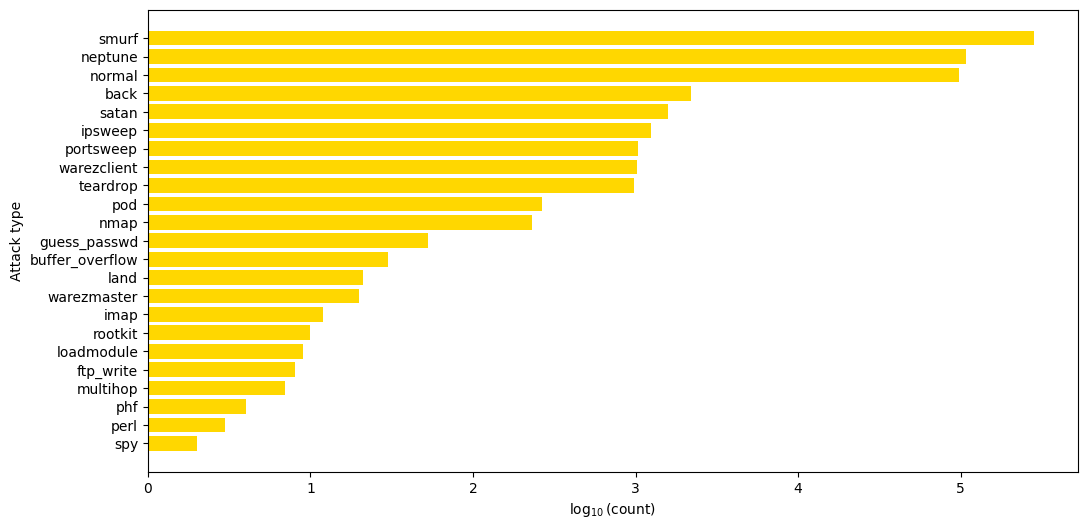

In [7]:
attacks, counts = np.unique(labels, return_counts=True)
ypos = np.arange(len(attacks))

attack_sort = np.argsort(counts)
attacks = attacks[attack_sort]
counts = counts[attack_sort]

plt.figure(figsize=(12, 6))
plt.barh(ypos, np.log10(counts), facecolor="gold")
plt.yticks(ypos, labels=[a.decode("utf-8")[0:-1] for a in attacks])
plt.xlabel(r"$\log_{10}(\mathrm{count})$")
plt.ylabel("Attack type")
plt.show()

# Pre-processing
We remove the “categorical” columns, and keep only the numerical ones. Then we rescale those to a [0, 1] range. Also, we remove two columns that happen to be all zeros. After all, this shouldn’t affect the clustering afterwards.

In [8]:
data = kdd[0]

kdd_rdd = sc.parallelize(
    [(0, {"features": data[i], "label": labels[i]}) for i in range(n_samples)],
    numSlices=64
)

In [9]:
def remove_bytes(x):
    # remove the elements with type 'bytes' (so, keep only the floats)
    mask = [type(i) != bytes for i in x[1]["features"]]
    feat_cut = np.asarray(x[1]["features"][mask], dtype=float)

    return (0, {"features": feat_cut, "label": x[1]["label"]})


kdd_rdd = kdd_rdd.map(remove_bytes)

In [10]:
def rescale(x, mins, maxs):
    # filter out columns with max == min
    mask = (mins < maxs).astype(bool)
    # rescale
    features = (x[1]["features"][mask] - mins[mask]) \
             / (maxs[mask] - mins[mask])
    
    return (0, {"features": features, "label": x[1]["label"]})
    

data_mins = kdd_rdd \
    .map(lambda x: x[1]["features"]) \
    .reduce(lambda x, y: np.minimum(x, y))

data_maxs = kdd_rdd \
    .map(lambda x: x[1]["features"]) \
    .reduce(lambda x, y: np.maximum(x, y))

kdd_rdd = kdd_rdd.map(lambda x: rescale(x, data_mins, data_maxs))

23/07/10 09:01:50 WARN TaskSetManager: Stage 0 contains a task of very large size (1783 KiB). The maximum recommended task size is 1000 KiB.
23/07/10 09:01:57 WARN TaskSetManager: Stage 1 contains a task of very large size (1783 KiB). The maximum recommended task size is 1000 KiB.


# `k-means` implementation

## Initialization functions

In [25]:
def stupid_init(rdd, n_clusters):
    # we have to sample n_clusters *different* points
    ## we can't call .distinct() on the rdd because np.array is not hashable,
    ## so we first add a key with the raw data string of the array and then
    ## "unique-ize" with reduceByKey
    centroids = rdd \
        .map(lambda x: (x[1]["features"].tobytes(), x[1]["features"])) \
        .reduceByKey(lambda x, y: x) \
        .values() \
        .takeSample(withReplacement=False, num=n_clusters)

    # return tuples with cluster_id and centroid position
    return [(i, c) for i, c in enumerate(centroids)]

In [31]:
def kplus_init(rdd, n_clusters):
    # pick first centroid at random
    c = rdd.takeSample(withReplacement=False, num=1)[0][1]["features"]
    centroids = np.empty((n_clusters, len(c)))
    centroids[0] = c

    for i in range(1, n_clusters):
        # compute all distances from the previously selected centroids
        distances = rdd \
            .map(lambda x: (x.tobytes(), np.sum((x[1]["features"] - centroids[:i])**2, axis=1))) \
            .persist()
        
        # compute cost function
        cost = distances.reduce(lambda x, y: x[1] + y[1])
        
        # cost-weighted sampling of the new centroid
        c = rdd


In [32]:
kplus_init(kdd_rdd, 5)

23/07/10 09:21:17 WARN TaskSetManager: Stage 35 contains a task of very large size (1783 KiB). The maximum recommended task size is 1000 KiB.
23/07/10 09:21:21 WARN TaskSetManager: Stage 36 contains a task of very large size (1783 KiB). The maximum recommended task size is 1000 KiB.
23/07/10 09:21:26 WARN TaskSetManager: Stage 37 contains a task of very large size (1783 KiB). The maximum recommended task size is 1000 KiB.
23/07/10 09:21:37 WARN TaskSetManager: Stage 38 contains a task of very large size (1783 KiB). The maximum recommended task size is 1000 KiB.
23/07/10 09:21:48 WARN TaskSetManager: Stage 39 contains a task of very large size (1783 KiB). The maximum recommended task size is 1000 KiB.
23/07/10 09:22:00 WARN TaskSetManager: Stage 40 contains a task of very large size (1783 KiB). The maximum recommended task size is 1000 KiB.


[[array([5.59128388,        inf,        inf,        inf,        inf]),
  array([5.5534321,       inf,       inf,       inf,       inf]),
  array([5.44973297,        inf,        inf,        inf,        inf]),
  array([5.32922637,        inf,        inf,        inf,        inf]),
  array([5.21893023,        inf,        inf,        inf,        inf]),
  array([5.09528547,        inf,        inf,        inf,        inf]),
  array([5.51409137,        inf,        inf,        inf,        inf]),
  array([5.18271011,        inf,        inf,        inf,        inf]),
  array([5.0758825,       inf,       inf,       inf,       inf]),
  array([5.02837421,        inf,        inf,        inf,        inf]),
  array([4.93930004,        inf,        inf,        inf,        inf]),
  array([4.99227352,        inf,        inf,        inf,        inf]),
  array([4.825641,      inf,      inf,      inf,      inf]),
  array([4.70872075,        inf,        inf,        inf,        inf]),
  array([4.92468526,      

In [33]:
import numpy.random as npr

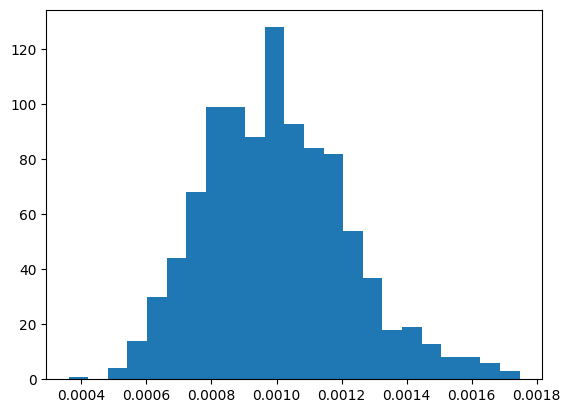

In [93]:
x = npr.normal(size=36)
y = x + npr.normal(scale=4, size=(1000, 36))

dist = [(s, np.sum((s - x)**2)) for s in y]

cost = 0
for i in range(len(dist)):
    cost += dist[i][1]
    
plt.hist(np.sum((y - x)**2, axis=1) / cost, bins="fd")
plt.show()

## Lloyd’s algorithm

In [26]:
def assign_to_cluster(sample, centroids):
    distances = np.sum((sample[1]["features"] - [c[1] for c in centroids])**2, axis=1)
    # get the cluster id from the closest centroid
    cluster_id = np.argmin(distances)

    return (centroids[cluster_id][0], sample[1])


def k_means(rdd, n_clusters, n_iters, init_func, *args, **kwargs):
    # get centroids from initalization function
    centroids = init_func(rdd, n_clusters, *args, **kwargs)

    for i in range(n_iters):        
        # find the nearest centroid to each sample
        # and cache the dataset in memory for faster access
        rdd_cached = rdd \
            .map(lambda x: assign_to_cluster(x, centroids)) \
            .persist()
        
        # update the centroids by averaging the points inside
        centroids = rdd_cached \
            .mapValues(lambda x: (x["features"], 1)) \
            .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])) \
            .mapValues(lambda x: x[0] / x[1]) \
            .collect()

        # clear the cache
        rdd_cached.unpersist()
        
    return centroids


In [27]:
%%time
k_means(kdd_rdd, k, 10, stupid_init)

23/07/10 07:53:15 WARN TaskSetManager: Stage 6 contains a task of very large size (2409 KiB). The maximum recommended task size is 1000 KiB.
23/07/10 07:53:23 WARN TaskSetManager: Stage 10 contains a task of very large size (2409 KiB). The maximum recommended task size is 1000 KiB.
23/07/10 07:53:34 WARN TaskSetManager: Stage 12 contains a task of very large size (2409 KiB). The maximum recommended task size is 1000 KiB.
23/07/10 07:53:44 WARN TaskSetManager: Stage 14 contains a task of very large size (2409 KiB). The maximum recommended task size is 1000 KiB.
23/07/10 07:53:53 WARN TaskSetManager: Stage 16 contains a task of very large size (2409 KiB). The maximum recommended task size is 1000 KiB.
23/07/10 07:54:03 WARN TaskSetManager: Stage 18 contains a task of very large size (2409 KiB). The maximum recommended task size is 1000 KiB.
23/07/10 07:54:13 WARN TaskSetManager: Stage 20 contains a task of very large size (2409 KiB). The maximum recommended task size is 1000 KiB.
23/07/1

CPU times: user 592 ms, sys: 203 ms, total: 796 ms
Wall time: 1min 45s


[(0,
  array([2.75556177e-03, 2.36822781e-05, 2.40388374e-03, 0.00000000e+00,
         0.00000000e+00, 2.63974131e-04, 7.96211971e-02, 2.37576717e-04,
         1.00000000e+00, 6.20145108e-04, 2.57374777e-03, 1.48485448e-03,
         9.85915465e-04, 2.22728173e-03, 3.56365076e-03, 1.60859236e-03,
         1.31855078e-01, 6.48957929e-03, 5.79684091e-03, 2.35398931e-03,
         1.29281330e-03, 3.44882202e-03, 2.94199168e-03, 9.66188873e-01,
         5.13007325e-02, 9.71688775e-03, 6.44603088e-01, 2.75772998e-01,
         3.07058008e-01, 8.06216591e-02, 1.32866759e-01, 2.30449416e-02,
         1.25994853e-02, 5.80875074e-03, 2.10255395e-02, 3.97149079e-03])),
 (1,
  array([8.82185903e-06, 4.17257380e-07, 9.45655747e-04, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 1.39926132e-04, 0.00000000e+00,
         1.00000000e+00, 1.04911469e-06, 3.41680090e-04, 0.00000000e+00,
         9.83110602e-08, 2.44057207e-05, 0.00000000e+00, 1.40332894e-04,
         0.00000000e+00, 1.59451027e-0

In [13]:
sc.stop()
spark.stop()